# Deep Guitar Amplifier

A little project to practice Tensorflow. I use deep learning to simulate a guitar amplifier following the approach published in [Wright et al., 2020](https://www.mdpi.com/2076-3417/10/3/766/htm)

In [1]:
# Open the ipython console
%qtconsole

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import spectrogram, get_window
from importlib import reload
import utils, models
reload(utils)
reload(models)
from utils import *
from models import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb
from sklearn.model_selection import train_test_split

# gpu memory management (attempt to allocate only as much memory as needed)
# check https://www.tensorflow.org/guide/gpu
# this instruction is required, otherwise cudnn returns errors
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline

# data directories
data_dir = "C:/Users/tore-/Dropbox/Projects/deep guitar amp emulation/datasets/guitar_amplifier_dataset/wav/"
data_proc_dir = 'datasets/guitar_amplifier_dataset/processed/'

# default samplerate for wav data (this variable is ovewritten if dataset is loaded)
samplerate = 44100

# amplifier to be modelled
amp = 'markII'
amp_gain = 'gain6'

# specify the device that tensorflow should use
# '/gpu:0' or '/cpu:0'
tf_device = '/gpu:0'

## 1 - Dataset

### Wave file processing

The next cell loads the wave files and chunks them into shorter time windows. It then shuffles the windows and splits them into a training, validation and test set (proportions: 80%, 10%, 10%). It finally saves the processed datasets to disk. 

Run this cell only if you want to change the dataset splits, otherwise skip and go directly to the next one.

In [20]:
# Load wave dataset
wavedata = load_wavedata(data_dir)

# Split wave data into chunks of Tx length (a few seconds long, so that they 
# can be listened to)
Tx = round(5*wavedata['samplerate']) 
X = data_chunk(wavedata['input'], Tx)
Y = data_chunk(wavedata[amp][amp_gain], Tx)

# shuffle and split into train, validation and test datasets
split_prop = [.8, .1, .1]
Xtrain, Xtest, Ytrain, Ytest = \
    train_test_split(X, Y, test_size=split_prop[2], random_state=1)
Xtrain, Xval, Ytrain, Yval = \
    train_test_split(Xtrain, Ytrain, test_size=split_prop[1]/np.sum(split_prop[:2]), random_state=1)

# save train, validation and test datasets
if not os.path.exists(data_proc_dir):
    os.makedirs(data_proc_dir)
np.savez(data_proc_dir + 'training_data.npz', \
         Xtrain=Xtrain, Ytrain=Ytrain, samplerate=wavedata['samplerate'])
np.savez(data_proc_dir + 'validation_data.npz', \
         Xval=Xval, Yval=Yval, samplerate=wavedata['samplerate'])
np.savez(data_proc_dir + 'test_data.npz', \
         Xtest=Xtest, Ytest=Ytest, samplerate=wavedata['samplerate'])

# free RAM
del wavedata, X, Y, Xtest, Ytest

### Dataset exploration

Load training and validation sets. Play and plot an example.

In [3]:
# Load processed wave data (training and validation sets)
training_data = np.load(data_proc_dir + 'training_data.npz')
validation_data = np.load(data_proc_dir + 'validation_data.npz')
samplerate = training_data['samplerate']
Xtrain = training_data['Xtrain']
Ytrain = training_data['Ytrain']
Xval = validation_data['Xval']
Yval = validation_data['Yval']

guitar


markII


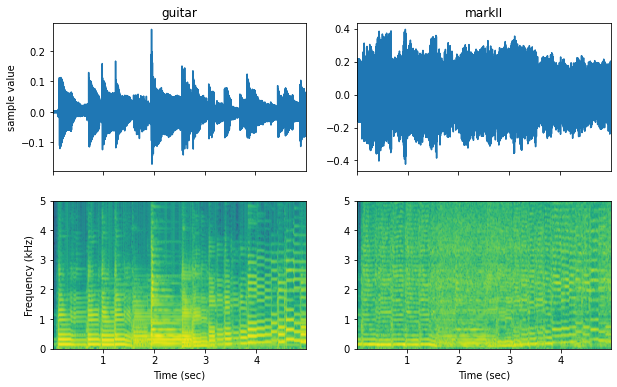

In [99]:
# Example of input/output from the training dataset
idx = 4; 
x = Xtrain[idx,:]
y = Ytrain[idx,:]
t = np.arange(0,len(x))/samplerate

# Play examples
print('guitar')
audio_playback_gui(x, file_name = 'guitar' + '_' + str(idx))
print(amp)
audio_playback_gui(y, file_name = amp + '_' + str(idx))

# Plot wave files
plt.figure(figsize=(10,6))
xlimits = (t[0],t[-1])
ax = plt.subplot(221)
plt.plot(t,x)
ax.set_xticklabels([])
plt.title('guitar')
plt.xlim(xlimits)
plt.ylabel('sample value')
ax = plt.subplot(222)
plt.plot(t,y)
plt.xlim(xlimits)
ax.set_xticklabels([])
plt.title(amp)

# Plot spectrograms 
df = 50; Tn = round_nextpow2(samplerate/df); Tn_overlap = int(.25*Tn)
myspectrogram = lambda x: spectrogram(x, window=get_window('hamming',Tn), fs=samplerate, noverlap=Tn_overlap)
f,t,S = myspectrogram(x)
#f,t,S = spectrogram(x, fs=samplerate)
f /= 1e3; ylimits = (0,5)
ax = plt.subplot(223)
plt.pcolormesh(t, f, 20*np.log10(S), shading='gouraud')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (sec)');
plt.ylim(ylimits)
_,_,S = myspectrogram(y)
ax = plt.subplot(224)
plt.pcolormesh(t, f, 20*np.log10(S), shading='gouraud')
plt.xlabel('Time (sec)');
plt.ylim(ylimits);

### Split examples into shorter time windows

The audio examples are now a few seconds long in order to enable listening. For training the model it is however more convenient to chunk the examples into much shorter time windows (sub-second).

In [4]:
# Tx chunks, overlapping by Trej; Trej is not included in the calculation of
# loss during training of the RNN model, to exclude the trainsients of the 
# model
Tx = round(.1*samplerate) 
Trej = round(.025*samplerate)

Xtrain = data_chunk(Xtrain, Tx, Trej)
Ytrain = data_chunk(Ytrain, Tx, Trej)
Xval = data_chunk(Xval, Tx, Trej)
Yval = data_chunk(Yval, Tx, Trej)

## 2 - Recurrent amplifier model

### Initialize a recurrent amplifier model

Initialize an amplifier model based on a recurrent neural network architecture.
Print model summary.

In [5]:
# specify the training path (where all training progress is going to be saved)
training_path = 'gru_model/'
if not os.path.exists(training_path): os.makedirs(training_path)

# create model
model = recurrent_model(units=32, 
                        celltype='GRU', 
                        Tx=Tx, 
                        Trej=Trej, 
                        preemphasis=True, 
                        print_summary=True, 
                        learning_rate=.01)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4410, 1)]    0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 4410, 32)     3360        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 4410, 1)      33          gru[0][0]                        
__________________________________________________________________________________________________
add (Add)                       (None, 4410, 1)      0           dense[0][0]                      
                                                                 input_1[0][0]                

If the current model has already undergone some training, you can **load the previously trained weights** by running the following cell.

In [6]:
# load trained weights
model.load_weights(training_path + 'weights.hdf5')

Show some baseline model outputs.

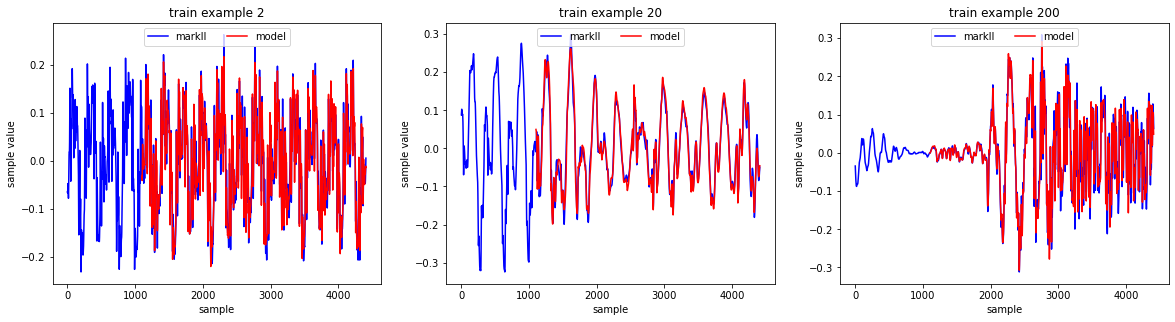

In [7]:
# compute model outputs
idx_vec = 2*np.array([1,10,100])
with tf.device(tf_device):
    y_hat = model.predict(Xtrain[idx_vec,:].reshape(len(idx_vec),Tx,1))

# plot
plt.figure(figsize=[20, 4.8])
for k,idx in enumerate(idx_vec):
    plt.subplot(1,len(idx_vec),k+1)
    plt.plot(Ytrain[idx,:],color='b')
    plt.plot(np.arange(Trej,Tx),y_hat[0][k,:,0],color='r')
    plt.xlabel('sample')
    plt.ylabel('sample value')
    plt.legend([amp,'model'], loc='upper center', ncol=2)
    plt.title('train example ' + str(idx));

### Model training

Train the model for a specified number of epochs by running the following cell.
The model weights that produce the lowest validation loss are saved in `<training_path>/weights.hdf5`. Training history is also saved in `<training_path>/history.csv`. Every time this cell is run, the corresponding history log is appended to `<training_path>/history.csv`.

Epoch 1/10
157/157 [==============================] - 60s 379ms/step - loss: 0.2890 - preemphasis_loss: 0.2655 - dc_loss: 0.0236 - preemphasis_esr: 0.2650 - preemphasis_dc: 5.2610e-04 - dc_esr: 19.5947 - dc_dc: 0.0235 - val_loss: 0.0731 - val_preemphasis_loss: 0.0728 - val_dc_loss: 3.1352e-04 - val_preemphasis_esr: 0.0727 - val_preemphasis_dc: 6.7658e-06 - val_dc_esr: 23.9343 - val_dc_dc: 3.1784e-04
Epoch 2/10
157/157 [==============================] - 60s 384ms/step - loss: 0.0665 - preemphasis_loss: 0.0652 - dc_loss: 0.0013 - preemphasis_esr: 0.0652 - preemphasis_dc: 2.7205e-05 - dc_esr: 24.2738 - dc_dc: 0.0013 - val_loss: 0.0586 - val_preemphasis_loss: 0.0584 - val_dc_loss: 2.0564e-04 - val_preemphasis_esr: 0.0583 - val_preemphasis_dc: 4.4269e-06 - val_dc_esr: 25.0482 - val_dc_dc: 2.1297e-04
Epoch 3/10
157/157 [==============================] - 63s 400ms/step - loss: 0.0595 - preemphasis_loss: 0.0581 - dc_loss: 0.0014 - preemphasis_esr: 0.0581 - preemphasis_dc: 2.9905e-05 - dc_esr: 

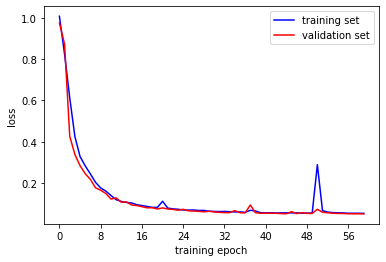

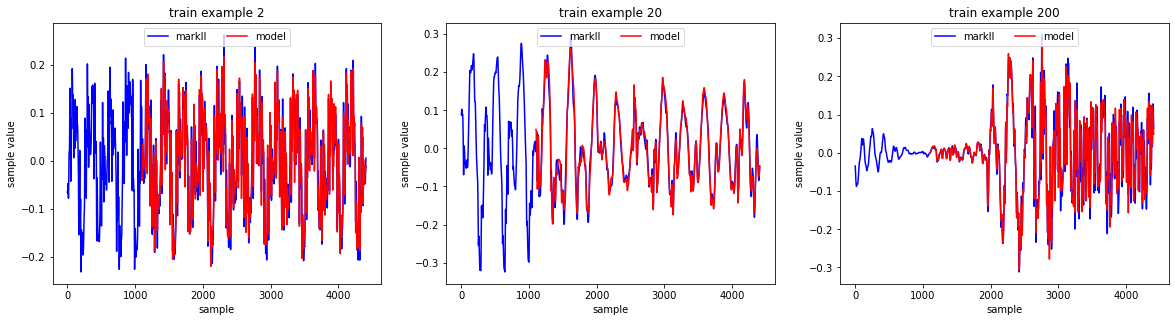

In [12]:
# Specify a callback to save the best model's weights
checkpoint_callback = keras.callbacks.ModelCheckpoint(\
    filepath=training_path + 'weights.hdf5',
    save_weights_only=True,
    save_best_only=True,
    monitor = 'val_loss')

# Callback to save training history
history_callback = keras.callbacks.CSVLogger(
    training_path + 'history.csv', 
    append=True)

# Callback to stop training if improvement is too low
stopping_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10)

callback_list = [
    checkpoint_callback,
    history_callback,
    stopping_callback,
    keras.callbacks.TerminateOnNaN()
]

# train
tic = time.process_time()
with tf.device(tf_device):
    model.fit(x = Xtrain[:,:,np.newaxis], 
                  y = Ytrain[:,Trej:,np.newaxis], 
                  epochs=10, 
                  batch_size=300, 
                  validation_data = (Xval[:,:,np.newaxis], \
                                     Yval[:,Trej:,np.newaxis]),
                  callbacks = callback_list
                 )
toc = time.process_time()
print('Total training time: ' + str((toc - tic)/60) + ' minutes')

# plot loss curves (training and validation losses)
history = pd.read_csv(training_path + 'history.csv')
ax = plt.figure().gca()
plt.plot(history['loss'], color='b')
plt.plot(history['val_loss'], color='r')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.legend(['training set','validation set'])
ax.xaxis.set_major_locator(MaxNLocator(integer=True));

# plot some example model outputs
with tf.device(tf_device):
    y_hat = model.predict(Xtrain[idx_vec,:].reshape(len(idx_vec),Tx,1))
plt.figure(figsize=[20, 4.8])
for k,idx in enumerate(idx_vec):
    plt.subplot(1,len(idx_vec),k+1)
    plt.plot(Ytrain[idx,:],color='b')
    plt.plot(np.arange(Trej,Tx),y_hat[0][k,:,0],color='r')
    plt.xlabel('sample')
    plt.ylabel('sample value')
    plt.legend([amp,'model'], loc='upper center', ncol=2)
    plt.title('train example ' + str(idx));

### Listen to some model outputs

Play some examples of model outputs from the validation set.

In [3]:
# Load processed wave data (training and validation sets)
validation_data = np.load(data_proc_dir + 'validation_data.npz')
samplerate = validation_data['samplerate']
Xval = validation_data['Xval']
Yval = validation_data['Yval']

# Choose model (set Tx=None, Trej=0. Since we are not training here)
model = recurrent_model(units=32, 
                        celltype='GRU',
                        Tx = np.shape(Xval)[1],
                        preemphasis=True, 
                        print_summary=False)
model.load_weights('gru_model/weights.hdf5')

# Compute model outputs from the validation set
with tf.device('/cpu:0'):
    Yval_hat = model.predict(Xval[:,:,np.newaxis])

In [18]:
# Choose example
idx = 5; 

# Play example
print(amp + '(original)')
audio_playback_gui(Yval[idx,-int(samplerate*4.5):], file_name = 'amp_original_' + str(idx))
print(amp + '(model)')
audio_playback_gui(Yval_hat[idx,-int(samplerate*4.5):,0], file_name = 'amp_model_' + str(idx))

markII(original)


markII(model)


## 3 - Convolutional amplifier model

In [17]:
Tx = Tx #None
nchannels = 10
nlayers = 10
Trej=24 
preemphasis_weights=[-.95,1]
print_summary=True
learning_rate=.001

# Single convolutional layer
def conv_block(X,k,dilation):
    Z = layers.Conv1D(filters = nchannels,
                      kernel_size = 2,
                      padding = 'causal',
                      dilation_rate = dilation,
                      activation = 'relu',
                      name = 'Z'+str(k))(X)
    Zmix = layers.Conv1D(1,1,name = 'Z'+str(k)+'_mix')(Z)
    X = layers.Add(name = 'X'+str(k+1))([X,Zmix])
    return X, Z

# Input layer
X_input = layers.Input(shape = (Tx,1), name = 'X0')
X = X_input

# Hidden layers - stacked dilated convolutional layers
Zlist = []
for k in range(nlayers):
    X, Z = conv_block(X,k,dilation=2**k)
    Zlist.append(Z)

# Output layer
Z = layers.Concatenate(axis=2, name='Z')(Zlist)
Y = layers.Conv1D(1,1,name = 'Y')(Z)

# Create model
model = keras.Model(inputs=[X_input], outputs=Y)
if print_summary:
    model.summary()

# Specify the preemphasis filter (used in the loss function)
if preemphasis_weights is not None:
    Preemphasis = tf.constant(preemphasis_weights, 
                              shape=[len(preemphasis_weights),1,1], 
                              dtype=tf.float32)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=opt, loss=esr_dc(Trej, Preemphasis), metrics=esr)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X0 (InputLayer)                 [(None, 4410, 1)]    0                                            
__________________________________________________________________________________________________
Z0 (Conv1D)                     (None, 4410, 10)     30          X0[0][0]                         
__________________________________________________________________________________________________
Z0_mix (Conv1D)                 (None, 4410, 1)      11          Z0[0][0]                         
__________________________________________________________________________________________________
X1 (Add)                        (None, 4410, 1)      0           X0[0][0]                         
                                                                 Z0_mix[0][0]               

In [148]:
# compute model outputs
# idx_vec = 2*np.array([1,10,100])
# with tf.device(tf_device):
#     y_hat = model.predict(Xtrain[idx_vec,:].reshape(len(idx_vec),Tx,1))

# # plot
# plt.figure(figsize=[20, 4.8])
# for k,idx in enumerate(idx_vec):
#     plt.subplot(1,len(idx_vec),k+1)
#     plt.plot(Ytrain[idx,:],color='b')
#     plt.plot(np.arange(Trej,Tx),y_hat[0][k,:,0],color='r')
#     plt.xlabel('sample')
#     plt.ylabel('sample value')
#     plt.legend([amp,'model'], loc='upper center', ncol=2)
#     plt.title('train example ' + str(idx));

In [9]:
Tx = np.shape(Xtrain)[1]
idx = [0,1]

# train
tic = time.process_time()
with tf.device('/gpu:0'):
    model.fit(x = Xtrain[idx,:].reshape(len(idx),Tx,1), 
                  y = Ytrain[idx,:].reshape(len(idx),Tx,1), 
                  epochs=1, 
                  batch_size=2
                 )
toc = time.process_time()
print('Total training time: ' + str((toc - tic)/60) + ' minutes')


1/1 [==============================] - 5s 5s/step - loss: 0.9989 - esr: 0.9927
Total training time: 0.06432291666666666 minutes
